# Prediksi Pesanan dalam Toko Daring Menggunakan Data Mining: Studi Kasus DATA MINING CUP 2013

# Kelompok 8
1. Hasbi Haqqul Fikri (2309245)
2. Naeya Adeani Putri (2304017)
3. Ririn Marchelina (2303662)
4. Muhammad Ichsan Khairullah (2306924)
5. Ismail Fatih Raihan (2307840)

# Pendahuluan

Kompetisi DATA MINING CUP (DMC) 2013 berfokus pada prediksi pesanan dalam sebuah toko daring (online shop). Dalam konteks ini, memprediksi kemungkinan terjadinya pesanan dapat memberikan keuntungan strategis bagi pengelola toko. Sebagai contoh, jika probabilitas pesanan tinggi, sistem dapat merekomendasikan produk-produk terlaris untuk meningkatkan penjualan. Sebaliknya, jika probabilitas rendah, sistem dapat menawarkan kupon diskon untuk mendorong pelanggan melakukan pembelian. Untuk mencapai prediksi yang akurat, berbagai metode data mining digunakan untuk menghitung probabilitas pesanan berdasarkan data transaksi yang terjadi selama sesi kunjungan pengguna.


Skenario yang dihadapi dalam kompetisi ini adalah sesi kunjungan pengguna ke sebuah toko daring, di mana pengguna mungkin akan melihat-lihat halaman produk, menambahkan atau menghapus produk dari keranjang belanja, dan pada akhir sesi mungkin melakukan pesanan. Tugas utama DMC tahun ini adalah untuk memprediksi apakah pengunjung akan melakukan pesanan atau tidak berdasarkan data transaksi yang terkumpul selama sesi tersebut.


Kompetisi DMC 2013 terdiri dari dua tugas utama. Tugas pertama adalah memprediksi hasil pesanan menggunakan data historis toko yang mencakup aktivitas sesi dan informasi apakah pesanan dilakukan atau tidak. Ini merupakan masalah klasik dalam data mining. Tugas kedua adalah skenario daring di mana peserta diharuskan mengimplementasikan agen yang mampu mempelajari pola transaksi secara adaptif dan memprediksi hasil pesanan secara real-time setelah setiap transaksi terjadi.

# Import Libraries

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb




# Menghubungkan Ke Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data Set

In [ ]:
df_data_train = pd.read_csv("/content/drive/MyDrive/DataMining/DataTugas2/transact_train.txt", delimiter='|')
df_data_class = pd.read_csv("/content/drive/MyDrive/DataMining/DataTugas2/transact_class.txt", delimiter='|')

# Data Exploration

In [ ]:
 # mengganti char ? menjadi  null value
df_data_train.replace('?', pd.NA, inplace=True)

# Convert appropriate columns to numeric, errors='coerce' will turn conversion errors into NaN
columns_to_convert = ['cMinPrice', 'cMaxPrice', 'cSumPrice', 'bMinPrice', 'bMaxPrice', 'bSumPrice',
                      'bStep', 'customerNo', 'maxVal', 'customerScore', 'accountLifetime',
                      'payments', 'age', 'address', 'lastOrder']

df_data_train[columns_to_convert] = df_data_train[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Calculate the number and percentage of missing values in each column
missing_values_count = df_data_train.isnull().sum()
missing_values_percentage = (missing_values_count / len(df_data_train)) * 100

missing_values_summary = pd.DataFrame({
    "Missing Values": missing_values_count,
    "Percentage (%)": missing_values_percentage
})

missing_values_summary.sort_values(by="Missing Values", ascending=False)

,Missing Values,Percentage (%)
bStep,191333,44.598415
availability,165255,38.519812
onlineStatus,160379,37.383249
customerScore,153740,35.835744
accountLifetime,153740,35.835744
maxVal,153740,35.835744
age,151396,35.289374
address,151098,35.219912
lastOrder,151098,35.219912
customerNo,151098,35.219912


In [ ]:
# Melihat distribusi kategori di kolom onlineStatus dan availability
online_status_counts = df_data_train['onlineStatus'].value_counts(dropna=False)
availability_counts = df_data_train['availability'].value_counts(dropna=False)

print("Distribusi Online Status:")
print(online_status_counts)
print("\nDistribusi Availability:")
print(availability_counts)

Distribusi Online Status:
onlineStatus
y       265625
<NA>    160379
n         3009
Name: count, dtype: int64

Distribusi Availability:
availability
completely orderable           253692
<NA>                           165255
mainly orderable                 5756
completely not orderable         1491
mixed                            1284
completely not determinable      1017
mainly not orderable              320
mainly not determinable           198
Name: count, dtype: int64


In [ ]:
# Filter the DataFrame based on the conditions
filtered_df = df_data_train[(df_data_train['availability'] == 'mainly not orderable') & (df_data_train['order'] == 'y')]

# Get the number of rows in the filtered DataFrame
num_lines = len(filtered_df)

# Print the result
print(f"Number of lines with 'completely orderable' and 'y': {num_lines}")

Number of lines with 'completely orderable' and 'y': 163


In [ ]:
df_data_train.head(500)

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,...,availability,customerNo,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,order
0,1,6,5,0.000,1,59.99,59.99,59.99,1,59.99,...,<NA>,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
1,1,6,5,11.940,1,59.99,59.99,59.99,1,59.99,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
2,1,6,5,39.887,1,59.99,59.99,59.99,1,59.99,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
3,2,6,5,0.000,0,NaN,NaN,NaN,0,NaN,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
4,2,6,5,15.633,0,NaN,NaN,NaN,0,NaN,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,66,6,5,438.157,0,NaN,NaN,NaN,0,NaN,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
496,66,6,5,454.460,1,NaN,NaN,NaN,1,NaN,...,<NA>,32.0,3000.0,570.0,224.0,7.0,51.0,2.0,212.0,y
497,66,6,5,458.102,1,NaN,NaN,NaN,1,NaN,...,mainly orderable,32.0,3000.0,570.0,224.0,7.0,51.0,2.0,212.0,y
498,66,6,5,475.089,1,NaN,NaN,NaN,1,NaN,...,completely orderable,32.0,3000.0,570.0,224.0,7.0,51.0,2.0,212.0,y


# Data Cleaning

## Availability

In [ ]:
# Memastikan kolom 'availability' memiliki nilai NaN sebelum menghitung modus
if df_data_train['availability'].isna().any():
    # Menghitung modus dari kolom 'availability'
    mode_availability = df_data_train['availability'].mode().iloc[0]

    # Mengisi nilai NaN pada kolom 'availability' dengan nilai modus
    df_data_train['availability'] = df_data_train['availability'].fillna(mode_availability)


In [ ]:
# Melihat distribusi kategori di kolom onlineStatus dan availability
online_status_counts = df_data_train['onlineStatus'].value_counts(dropna=False)
availability_counts = df_data_train['availability'].value_counts(dropna=False)

print("Distribusi Online Status:")
print(online_status_counts)
print("\nDistribusi Availability:")
print(availability_counts)

Distribusi Online Status:
onlineStatus
y       265625
<NA>    160379
n         3009
Name: count, dtype: int64

Distribusi Availability:
availability
completely orderable           418947
mainly orderable                 5756
completely not orderable         1491
mixed                            1284
completely not determinable      1017
mainly not orderable              320
mainly not determinable           198
Name: count, dtype: int64


In [ ]:
df_data_train.head(500)

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,...,availability,customerNo,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,order
0,1,6,5,0.000,1,59.99,59.99,59.99,1,59.99,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
1,1,6,5,11.940,1,59.99,59.99,59.99,1,59.99,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
2,1,6,5,39.887,1,59.99,59.99,59.99,1,59.99,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
3,2,6,5,0.000,0,NaN,NaN,NaN,0,NaN,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
4,2,6,5,15.633,0,NaN,NaN,NaN,0,NaN,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,66,6,5,438.157,0,NaN,NaN,NaN,0,NaN,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
496,66,6,5,454.460,1,NaN,NaN,NaN,1,NaN,...,completely orderable,32.0,3000.0,570.0,224.0,7.0,51.0,2.0,212.0,y
497,66,6,5,458.102,1,NaN,NaN,NaN,1,NaN,...,mainly orderable,32.0,3000.0,570.0,224.0,7.0,51.0,2.0,212.0,y
498,66,6,5,475.089,1,NaN,NaN,NaN,1,NaN,...,completely orderable,32.0,3000.0,570.0,224.0,7.0,51.0,2.0,212.0,y


Kesimpulan

Memeriksa apakah terdapat nilai NaN pada kolom 'availability' dalam dataframe df_data_train. Jika terdapat nilai NaN, kode akan melanjutkan untuk menghitung modus dari kolom tersebut menggunakan df_data_train['availability'].mode().iloc[0], yang mengambil nilai paling sering muncul. Setelah nilai modus diperoleh, kode mengisi seluruh nilai NaN dalam kolom 'availability' dengan nilai modus tersebut menggunakan metode fillna() dengan inplace=True, sehingga perubahan ini langsung diterapkan pada dataframe asli.

## cPrice

In [ ]:
#print(df_data_train[['cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice']].head(50))

# Menghitung mean untuk cMinPrice dan cMaxPrice, serta median untuk cSumPrice
mean_cMinPrice = df_data_train['cMinPrice'].mean()
mean_cMaxPrice = df_data_train['cMaxPrice'].mean()
median_cSumPrice = df_data_train['cSumPrice'].median()

# Mengisi nilai NaN di cMinPrice, cMaxPrice, dan cSumPrice hanya jika cCount > 0
#df_data_train.loc[(df_data_train['cCount'] > 0) & (df_data_train['cMinPrice'].isna()), 'cMinPrice'] = mean_cMinPrice
#df_data_train.loc[(df_data_train['cCount'] > 0) & (df_data_train['cMaxPrice'].isna()), 'cMaxPrice'] = mean_cMaxPrice
#df_data_train.loc[(df_data_train['cCount'] > 0) & (df_data_train['cSumPrice'].isna()), 'cSumPrice'] = median_cSumPrice

# Replace NaN in cMinPrice, cMaxPrice, and cSumPrice only if cCount > 0
df_data_train.loc[(df_data_train['cCount'] > 0) & (df_data_train['cMinPrice'].isna()), 'cMinPrice'] = mean_cMinPrice
df_data_train.loc[(df_data_train['cCount'] > 0) & (df_data_train['cMaxPrice'].isna()), 'cMaxPrice'] = mean_cMaxPrice
df_data_train.loc[(df_data_train['cCount'] > 0) & (df_data_train['cSumPrice'].isna()), 'cSumPrice'] = median_cSumPrice

# Replace cPrice variables with 0 where cCount is 0
df_data_train.loc[df_data_train['cCount'] == 0, ['cMinPrice', 'cMaxPrice', 'cSumPrice']] = 0

# Menampilkan beberapa baris pertama untuk memverifikasi pengisian nilai NaN
print(df_data_train[['cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice']].head(100))

# Filter the DataFrame for rows with 0 cCount and cMinPrice greater than 0
filtered_df = df_data_train[(df_data_train['cCount'] == 0) & (df_data_train['cSumPrice'] > 0)]

# Get the number of rows in the filtered DataFrame
num_rows = len(filtered_df)

# Print the result
print(f"Number of rows with 0 cCount but cMinPrice > 0: {num_rows}")

    cCount  cMinPrice  cMaxPrice  cSumPrice
0        1      59.99      59.99      59.99
1        1      59.99      59.99      59.99
2        1      59.99      59.99      59.99
3        0       0.00       0.00       0.00
4        0       0.00       0.00       0.00
..     ...        ...        ...        ...
95      21       5.99      59.99     456.77
96      21       5.99      59.99     456.77
97       0       0.00       0.00       0.00
98       0       0.00       0.00       0.00
99       0       0.00       0.00       0.00

[100 rows x 4 columns]
Number of rows with 0 cCount but cMinPrice > 0: 0


In [ ]:
# Filter the DataFrame to include only rows where cSumPrice is greater than 1000
filtered_df = df_data_train[df_data_train['cSumPrice'] > 1000]

# Get the number of rows in the filtered DataFrame
count_exceeding_1000 = len(filtered_df)

# Print the result
print(f"Number of cSumPrice values exceeding 1000: {count_exceeding_1000}")

Number of cSumPrice values exceeding 1000: 110429


In [ ]:
df_data_train.head(500)

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,...,availability,customerNo,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,order
0,1,6,5,0.000,1,59.990000,59.990000,59.99,1,59.99,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
1,1,6,5,11.940,1,59.990000,59.990000,59.99,1,59.99,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
2,1,6,5,39.887,1,59.990000,59.990000,59.99,1,59.99,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
3,2,6,5,0.000,0,0.000000,0.000000,0.00,0,NaN,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
4,2,6,5,15.633,0,0.000000,0.000000,0.00,0,NaN,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,66,6,5,438.157,0,0.000000,0.000000,0.00,0,NaN,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
496,66,6,5,454.460,1,55.289127,146.663005,388.00,1,NaN,...,completely orderable,32.0,3000.0,570.0,224.0,7.0,51.0,2.0,212.0,y
497,66,6,5,458.102,1,55.289127,146.663005,388.00,1,NaN,...,mainly orderable,32.0,3000.0,570.0,224.0,7.0,51.0,2.0,212.0,y
498,66,6,5,475.089,1,55.289127,146.663005,388.00,1,NaN,...,completely orderable,32.0,3000.0,570.0,224.0,7.0,51.0,2.0,212.0,y


Kesimpulan


Untuk memproses data pada kolom-kolom terkait harga (cMinPrice, cMaxPrice, cSumPrice) dan jumlah (cCount) dalam dataframe df_data_train. Pertama, kode menghitung nilai rata-rata (mean) dan median untuk kolom harga sebagai acuan pengisian nilai NaN. Jika cCount lebih dari 0, nilai NaN pada kolom harga diisi dengan nilai rata-rata atau median yang telah dihitung. Namun, jika cCount bernilai 0, semua kolom harga diatur menjadi 0. Selanjutnya, kode menampilkan beberapa baris pertama untuk memverifikasi bahwa pengisian nilai NaN telah berhasil.

## bPrice

In [ ]:


# Menghitung mean untuk bMinPrice dan bMaxPrice, serta median untuk bSumPrice
mean_bMinPrice = df_data_train['bMinPrice'].mean()
mean_bMaxPrice = df_data_train['bMaxPrice'].mean()
median_bSumPrice = df_data_train['bSumPrice'].median()

# Mengisi nilai NaN di bMinPrice, bMaxPrice, dan bSumPrice berdasarkan kondisi bCount > 0
#df_data_train.loc[(df_data_train['bCount'] > 0) & (df_data_train['bMinPrice'].isna()), 'bMinPrice'] = mean_bMinPrice
#df_data_train.loc[(df_data_train['bCount'] > 0) & (df_data_train['bMaxPrice'].isna()), 'bMaxPrice'] = mean_bMaxPrice
#df_data_train.loc[(df_data_train['bCount'] > 0) & (df_data_train['bSumPrice'].isna()), 'bSumPrice'] = median_bSumPrice

df_data_train.loc[(df_data_train['bCount'] > 0) & (df_data_train['bMinPrice'].isna()), 'bMinPrice'] = mean_bMinPrice
df_data_train.loc[(df_data_train['bCount'] > 0) & (df_data_train['bMaxPrice'].isna()), 'bMaxPrice'] = mean_bMaxPrice
df_data_train.loc[(df_data_train['bCount'] > 0) & (df_data_train['bSumPrice'].isna()), 'bSumPrice'] = median_bSumPrice

# Replace cPrice variables with 0 where cCount is 0
df_data_train.loc[df_data_train['bCount'] == 0, ['bMinPrice', 'bMaxPrice', 'bSumPrice']] = 0

# Menampilkan beberapa baris pertama untuk memverifikasi pengisian nilai NaN

df_data_train[['bCount', 'bMinPrice', 'bMaxPrice', 'bSumPrice']].head(100)

,bCount,bMinPrice,bMaxPrice,bSumPrice
0,1,59.99,59.99,59.99
1,1,59.99,59.99,59.99
2,1,59.99,59.99,59.99
3,0,0.00,0.00,0.00
4,0,0.00,0.00,0.00
...,...,...,...,...
95,11,5.99,59.99,258.38
96,11,5.99,59.99,258.38
97,0,0.00,0.00,0.00
98,0,0.00,0.00,0.00


In [ ]:
# Filter the DataFrame for rows with 0 cCount and cMinPrice greater than 0
filtered_df = df_data_train[(df_data_train['cCount'] == 0) & (df_data_train['cMinPrice'] > 0)]

# Get the number of rows in the filtered DataFrame
num_rows = len(filtered_df)

# Print the result
print(f"Number of rows with 0 cCount but cMinPrice > 0: {num_rows}")

Number of rows with 0 cCount but cMinPrice > 0: 0


In [ ]:
# Filter the DataFrame to include only rows where cSumPrice is greater than 1000
filtered_df = df_data_train[df_data_train['bSumPrice'] > 1000]

# Get the number of rows in the filtered DataFrame
count_exceeding_1000 = len(filtered_df)

# Print the result
print(f"Number of cSumPrice values exceeding 1000: {count_exceeding_1000}")

Number of cSumPrice values exceeding 1000: 13788


In [ ]:
df_data_train.head(500)

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,...,availability,customerNo,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,order
0,1,6,5,0.000,1,59.990000,59.990000,59.99,1,59.990000,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
1,1,6,5,11.940,1,59.990000,59.990000,59.99,1,59.990000,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
2,1,6,5,39.887,1,59.990000,59.990000,59.99,1,59.990000,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
3,2,6,5,0.000,0,0.000000,0.000000,0.00,0,0.000000,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
4,2,6,5,15.633,0,0.000000,0.000000,0.00,0,0.000000,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,66,6,5,438.157,0,0.000000,0.000000,0.00,0,0.000000,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
496,66,6,5,454.460,1,55.289127,146.663005,388.00,1,67.625341,...,completely orderable,32.0,3000.0,570.0,224.0,7.0,51.0,2.0,212.0,y
497,66,6,5,458.102,1,55.289127,146.663005,388.00,1,67.625341,...,mainly orderable,32.0,3000.0,570.0,224.0,7.0,51.0,2.0,212.0,y
498,66,6,5,475.089,1,55.289127,146.663005,388.00,1,67.625341,...,completely orderable,32.0,3000.0,570.0,224.0,7.0,51.0,2.0,212.0,y


Kesimpulan

bertujuan untuk mengelola nilai NaN pada kolom-kolom harga (bMinPrice, bMaxPrice, bSumPrice) dengan menghitung nilai rata-rata dan median sebagai acuan pengisian. Jika nilai bCount lebih dari 0, nilai NaN pada kolom harga akan diisi dengan nilai rata-rata atau median yang sesuai. Namun, jika bCount bernilai 0, semua kolom harga tersebut diatur menjadi 0.

## bStep

In [ ]:
# Menghitung modus dari kolom bStep
mode_bStep = df_data_train['bStep'].mode()[0]  # Mendapatkan nilai paling sering muncul

# Mengisi nilai NaN pada kolom bStep dengan nilai modus tanpa inplace=True
df_data_train['bStep'] = df_data_train['bStep'].fillna(mode_bStep)

# Menampilkan hasil
print(f"The mode value used for bStep imputation is: {mode_bStep}")
print(df_data_train['bStep'].head(50))


The mode value used for bStep imputation is: 1.0
0     1.0
1     2.0
2     1.0
3     2.0
4     1.0
5     4.0
6     4.0
7     1.0
8     1.0
9     1.0
10    1.0
11    4.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    4.0
21    4.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    2.0
29    2.0
30    1.0
31    4.0
32    1.0
33    1.0
34    1.0
35    1.0
36    1.0
37    1.0
38    1.0
39    4.0
40    1.0
41    1.0
42    1.0
43    2.0
44    2.0
45    3.0
46    4.0
47    5.0
48    1.0
49    1.0
Name: bStep, dtype: float64


Kesimpulan

Menghitung nilai modus dari kolom bStep dalam dataframe df_data_train dan menggunakan nilai tersebut, yaitu 1.0, untuk mengisi semua nilai NaN yang ada di kolom tersebut. Dengan demikian, kolom bStep menjadi konsisten tanpa ada nilai kosong.

## OnlineStatus

##### Just messing around

In [ ]:
# Filter the DataFrame for rows where 'order' is 'y'
filtered_df = df_data_train[df_data_train['order'] == 'y']

# Count the occurrences of 'n' in the 'onlineStatus' column of the filtered DataFrame
n_count = filtered_df['onlineStatus'].value_counts()['n']

# Get the number of rows using the 'shape' attribute
num_rows = df_data_train.shape[0]

# Print the result
print(f"Number of onlineStatus values set to 'n': {n_count} out of {num_rows}")

Number of onlineStatus values set to 'n': 1260 out of 429013


##### Actual code

In [ ]:
# Rule-based imputation
df_data_train.loc[(df_data_train['order'] == 'y') & (df_data_train['onlineStatus'].isna()), 'onlineStatus'] = 'y'

# Mode imputation for remaining missing values
# Menghitung modus dari kolom onlineStatus
mode_onlineStatus = df_data_train['onlineStatus'].mode()[0]

# Mengisi sisa nilai NaN pada kolom onlineStatus dengan nilai modus tanpa inplace=True
df_data_train['onlineStatus'] = df_data_train['onlineStatus'].fillna(mode_onlineStatus)

# Menampilkan hasil untuk verifikasi
print(f"The mode value used for onlineStatus imputation is: {mode_onlineStatus}")
print(df_data_train[['sessionNo', 'onlineStatus', 'order']].head(50))


The mode value used for onlineStatus imputation is: y
    sessionNo onlineStatus order
0           1            y     y
1           1            y     y
2           1            y     y
3           2            y     y
4           2            y     y
5           2            y     y
6           2            y     y
7           2            y     y
8           3            y     y
9           3            y     y
10          3            y     y
11          3            y     y
12          3            y     y
13          4            y     n
14          4            y     n
15          5            y     y
16          5            y     y
17          5            y     y
18          5            y     y
19          5            y     y
20          5            y     y
21          5            y     y
22          5            y     y
23          6            y     n
24          6            y     n
25          6            y     n
26          7            y     y
27          7         

Kesimpulan

Mengisi nilai kosong di kolom onlineStatus dengan pendekatan yang sistematis. Pertama, kode memfilter data untuk menemukan baris di mana kolom order bernilai 'y' dan onlineStatus bernilai NaN, lalu mengisi nilai onlineStatus tersebut dengan 'y'. Selanjutnya, untuk nilai NaN yang tersisa di kolom onlineStatus, kode menggunakan metode imputasi modus, yaitu mengisi nilai kosong dengan nilai yang paling sering muncul di kolom tersebut.

## CustomerNo

Kelompok kami memutuskan untuk tidak melakukan imputasi terhadap kolom customerNo, alasan utamanya adalah potensi hilangnya informasi (loss of information). customerNo merupakan identifier unik untuk setiap pelanggan. Jika kami melakukan imputasi, terutama dengan menggunakan metode seperti mean, median, atau modus, kami akan menciptakan data artifisial yang tidak mencerminkan identitas pelanggan yang sebenarnya.


Berikut penjelasan lebih detail:


1. Keunikan customerNo: Setiap nilai pada kolom customerNo seharusnya unik dan mewakili satu pelanggan. Imputasi dengan nilai yang sudah ada akan menciptakan duplikat atau data yang tidak valid, sehingga mengaburkan informasi asli tentang pelanggan.

2. Informasi yang Hilang: Nilai kosong pada customerNo mungkin memiliki arti tersendiri. Misalnya, bisa jadi data tersebut memang tidak tercatat, pelanggan baru, atau pelanggan yang memilih untuk tidak memberikan informasi tersebut. Imputasi akan menghilangkan informasi penting ini dan berpotensi mengubah pola data asli.

3. Potensi Bias: Jika kami mengimputasi customerNo dengan nilai yang ada, kami berpotensi menciptakan bias dalam analisis. Misalnya, jika kami menggunakan modus atau median, kami akan memberikan nilai yang paling sering muncul atau nilai tengah kepada pelanggan dengan customerNo kosong. Hal ini dapat menghasilkan kesimpulan yang tidak akurat tentang perilaku pelanggan.

## MaxVal

In [ ]:
# Menghitung mean dan median dari maxVal, mengabaikan nilai NaN
mean_maxVal = df_data_train['maxVal'].mean(skipna=True)
median_maxVal = df_data_train['maxVal'].median(skipna=True)

print("Rata-rata dari maxVal:", mean_maxVal)
print("Median dari maxVal:", median_maxVal)

Rata-rata dari maxVal: 2486.3582697903535
Median dari maxVal: 1500.0


Kesimpulan

Menghitung nilai rata-rata dan median dari kolom maxVal, mengabaikan nilai NaN dalam perhitungannya. Hasilnya menunjukkan bahwa nilai rata-rata dari maxVal adalah 2486.36, sedangkan nilai mediannya adalah 1500.0. Hal ini memberikan gambaran umum tentang distribusi data pada kolom maxVal, di mana nilai rata-rata lebih tinggi dibandingkan median, yang dapat mengindikasikan adanya data dengan nilai tinggi yang signifikan di kolom tersebut.

## Age

In [ ]:
# Hitung rata-rata usia, abaikan NaN, dan bulatkan ke bilangan bulat terdekat
mean_age = round(df_data_train['age'].mean(skipna=True))

# Isi nilai NaN dengan rata-rata yang telah dibulatkan
df_data_train['age'] = df_data_train['age'].fillna(mean_age)

# Bulatkan semua nilai dalam kolom 'age' ke bilangan bulat terdekat
df_data_train['age'] = df_data_train['age'].round()

# Tampilkan DataFrame untuk memeriksa hasil
df_data_train.head(100)

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,...,availability,customerNo,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,order
0,1,6,5,0.000,1,59.99,59.99,59.99,1,59.99,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
1,1,6,5,11.940,1,59.99,59.99,59.99,1,59.99,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
2,1,6,5,39.887,1,59.99,59.99,59.99,1,59.99,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
3,2,6,5,0.000,0,0.00,0.00,0.00,0,0.00,...,completely orderable,NaN,NaN,NaN,NaN,NaN,45.0,NaN,NaN,y
4,2,6,5,15.633,0,0.00,0.00,0.00,0,0.00,...,completely orderable,NaN,NaN,NaN,NaN,NaN,45.0,NaN,NaN,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,12,6,5,1516.055,21,5.99,59.99,456.77,11,5.99,...,completely orderable,8.0,2000.0,546.0,364.0,11.0,86.0,2.0,37.0,y
96,12,6,5,1540.895,21,5.99,59.99,456.77,11,5.99,...,completely orderable,8.0,2000.0,546.0,364.0,11.0,86.0,2.0,37.0,y
97,13,6,5,0.000,0,0.00,0.00,0.00,0,0.00,...,completely orderable,NaN,NaN,NaN,NaN,NaN,45.0,NaN,NaN,y
98,13,6,5,60.412,0,0.00,0.00,0.00,0,0.00,...,completely orderable,NaN,NaN,NaN,NaN,NaN,45.0,NaN,NaN,y


Kesimpulan

Menghitung nilai rata-rata kolom age, mengabaikan nilai NaN, dan membulatkan hasilnya ke bilangan bulat terdekat. Nilai rata-rata yang telah dibulatkan ini kemudian digunakan untuk mengisi semua nilai NaN pada kolom age, sehingga kolom tersebut tidak memiliki nilai kosong.

##Payment


In [ ]:
# Menghitung median dari kolom payments
median_payment = df_data_train['payments'].median()

# Mengisi nilai NaN pada kolom payments dengan nilai median tanpa inplace=True
df_data_train['payments'] = df_data_train['payments'].fillna(median_payment)

# Menampilkan 100 baris pertama untuk verifikasi
print(df_data_train.head(100))


    sessionNo  startHour  startWeekday  duration  cCount  cMinPrice  \
0           1          6             5     0.000       1      59.99   
1           1          6             5    11.940       1      59.99   
2           1          6             5    39.887       1      59.99   
3           2          6             5     0.000       0       0.00   
4           2          6             5    15.633       0       0.00   
..        ...        ...           ...       ...     ...        ...   
95         12          6             5  1516.055      21       5.99   
96         12          6             5  1540.895      21       5.99   
97         13          6             5     0.000       0       0.00   
98         13          6             5    60.412       0       0.00   
99         13          6             5    83.180       0       0.00   

    cMaxPrice  cSumPrice  bCount  bMinPrice  ...          availability  \
0       59.99      59.99       1      59.99  ...  completely orderable   

Kesimpulan

Menghitung nilai median dari kolom payments dalam dataframe df_data_train dan menggunakan nilai tersebut untuk mengisi semua nilai NaN yang ada di kolom tersebut. Dengan demikian, kolom payments tidak lagi memiliki nilai kosong dan semua nilai NaN telah digantikan oleh nilai median, sehingga data lebih konsisten dan siap untuk analisis lebih lanjut.

##Address

In [ ]:
# Hitung modus dari kolom address
address_mode = df_data_train['address'].mode()[0]

# Isi nilai NaN dengan modus
df_data_train['address'] = df_data_train['address'].fillna(address_mode)

# Cetak nilai modus
print("Modus dari kolom 'address' adalah:", address_mode)

# Cetak DataFrame setelah perubahan
df_data_train.head(5111)

Modus dari kolom 'address' adalah: 2.0


,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,...,availability,customerNo,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,order
0,1,6,5,0.000,1,59.99,59.99,59.99,1,59.99,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
1,1,6,5,11.940,1,59.99,59.99,59.99,1,59.99,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
2,1,6,5,39.887,1,59.99,59.99,59.99,1,59.99,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
3,2,6,5,0.000,0,0.00,0.00,0.00,0,0.00,...,completely orderable,NaN,NaN,NaN,NaN,8.0,45.0,2.0,NaN,y
4,2,6,5,15.633,0,0.00,0.00,0.00,0,0.00,...,completely orderable,NaN,NaN,NaN,NaN,8.0,45.0,2.0,NaN,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5106,694,8,5,1107.539,29,29.99,54.90,1184.16,7,29.99,...,completely orderable,322.0,600.0,443.0,15.0,18.0,58.0,2.0,11.0,n
5107,694,8,5,1141.662,30,29.99,54.90,1214.15,7,29.99,...,completely orderable,322.0,600.0,443.0,15.0,18.0,58.0,2.0,11.0,n
5108,694,8,5,1151.906,30,29.99,54.90,1214.15,7,29.99,...,completely orderable,322.0,600.0,443.0,15.0,18.0,58.0,2.0,11.0,n
5109,694,8,5,1163.387,30,29.99,54.90,1214.15,7,29.99,...,completely orderable,322.0,600.0,443.0,15.0,18.0,58.0,2.0,11.0,n


Kesimpulan


Menghitung nilai modus dari kolom address dalam dataframe df_data_train, dan menggunakan nilai modus tersebut (yaitu 2.0) untuk mengisi semua nilai NaN di kolom address. Setelah pengisian, kolom address tidak lagi memiliki nilai kosong, sehingga data lebih konsisten dan siap untuk analisis lebih lanjut. Kode ini juga menampilkan dataframe yang telah dimodifikasi, memperlihatkan hasil akhir di mana nilai NaN di kolom address telah digantikan dengan nilai yang paling sering muncul.

## lastOrder

In [ ]:
# Menampilkan kolom lastOrder (10 baris pertama)
print(df_data_train['lastOrder'].head(10))

# Menghitung mean dan median dari kolom lastOrder
mean_lastOrder = df_data_train['lastOrder'].mean()
median_lastOrder = df_data_train['lastOrder'].median()

# Menampilkan hasil mean dan median
print(f"Mean of lastOrder: {mean_lastOrder}")
print(f"Median of lastOrder: {median_lastOrder}")

# Mengisi nilai NaN pada kolom lastOrder dengan median tanpa inplace=True
df_data_train['lastOrder'] = df_data_train['lastOrder'].fillna(median_lastOrder)
df_data_train['lastOrder'].head(500)


0    49.0
1    49.0
2    49.0
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8    11.0
9    11.0
Name: lastOrder, dtype: float64
Mean of lastOrder: 79.8839753161938
Median of lastOrder: 34.0


,lastOrder
0,49.0
1,49.0
2,49.0
3,34.0
4,34.0
...,...
495,34.0
496,212.0
497,212.0
498,212.0


Kesimpulan

Menghitung nilai rata-rata (mean) dan median dari kolom lastOrder dalam dataframe df_data_train. Hasilnya menunjukkan bahwa nilai rata-rata dari lastOrder adalah 79.89, sementara mediannya adalah 34.0. Selanjutnya, kode ini mengisi semua nilai NaN pada kolom lastOrder dengan nilai median (34.0) untuk memastikan konsistensi data. Setelah pengisian, kolom lastOrder tidak lagi memiliki nilai kosong, dan hasil akhir ditampilkan untuk memverifikasi perubahan.

# Plotting dan Analisis

###Statistik dasar dari datasetnya

In [ ]:
# 1. Jumlah record data
print('1. Jumlah record data = {}, dan jumlah kolom = 24'.format(df_data_train.shape[0]))
# 2. Tampilkan jumlah orang yang order (y) dan tidak order (n)
print("\n2. Jumlah Order (y) dan jumlah Tidak Order (n)")
print(df_data_train.loc[:, 'order'].value_counts())
print("3. Data Order bersifat Imbalance, yaitu data Order (y) lebih banyak dari yang Tidak Order (n)")

1. Jumlah record data = 429013, dan jumlah kolom = 24

2. Jumlah Order (y) dan jumlah Tidak Order (n)
order
y    290030
n    138983
Name: count, dtype: int64
3. Data Order bersifat Imbalance, yaitu data Order (y) lebih banyak dari yang Tidak Order (n)


##Heatmap yang menunjukkan koefisien korelasi antara berbagai fitur dalam dataset

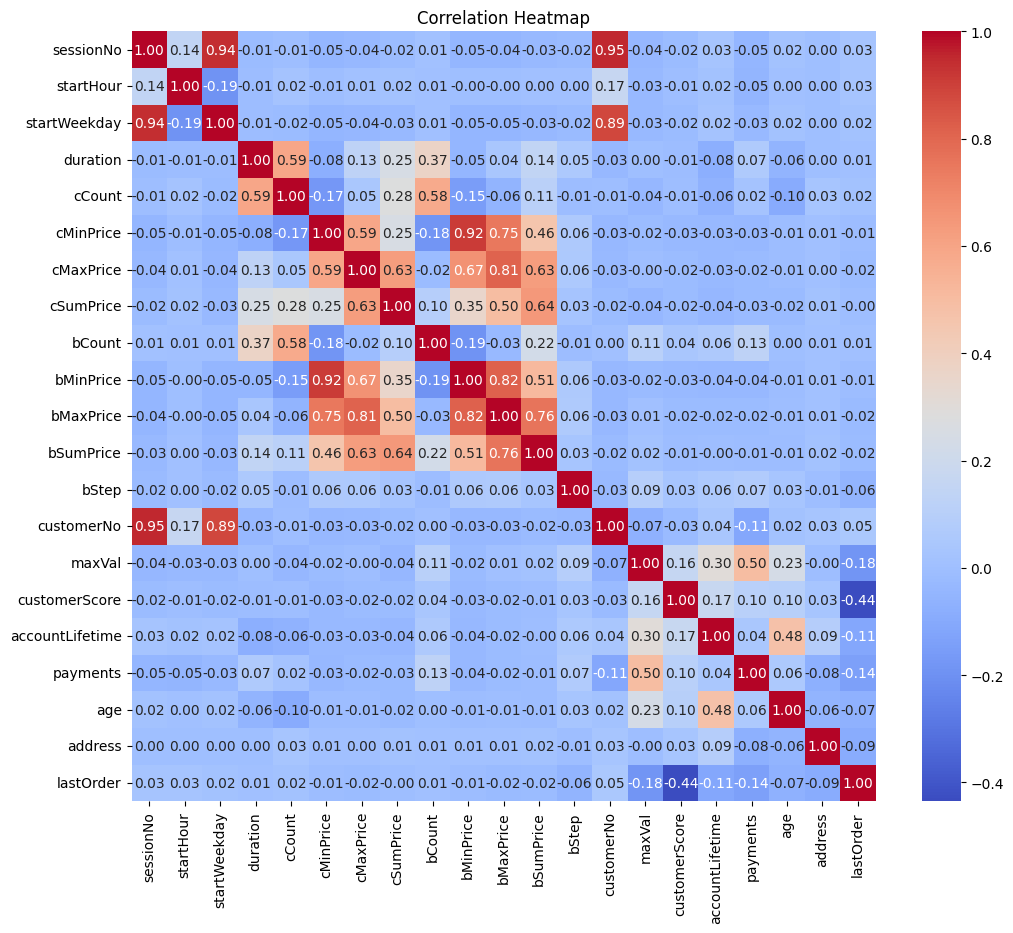

In [ ]:
# Menampilkan Heatmap untuk mencari korelasi antar kolom, bagaimana pola menarik yang ada pada dataset ini
df_numerik = df_data_train.select_dtypes(include=['number'])
correlation_matrix = df_numerik.corr()
plt.figure(figsize=(12, 10))  # Adjust figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

###Kesimpulan
####Korelasi Positif Kuat:

####sessionNo dan customerNo (0,95): Setiap sesi kemungkinan terkait pelanggan tertentu.
####bMaxPrice dengan bMinPrice (0,92), cSumPrice (0,76), dan bSumPrice (0,82): Harga maksimum tinggi cenderung terkait dengan harga dan jumlah harga yang lebih tinggi.
####Korelasi Negatif Kuat:

####sessionNo dan startWeekday (-0,94): Ketika salah satu naik, lainnya menurun.
####customerNo dan startWeekday (-0,89): Pelanggan tertentu aktif di hari tertentu.
####Korelasi Sedang:

####bCount dan cCount (0,58): Jumlah pada satu kategori cukup terkait dengan lainnya.
####accountLifetime dan age (0,48): Umur akun yang lebih lama mungkin terkait dengan usia pelanggan yang lebih tua.
####Korelasi Lemah atau Tidak Ada Korelasi:

####lastOrder, payments, dan address: Korelasi lemah dengan fitur lain, sehingga pengaruhnya mungkin rendah.

##Diagram batang untuk menunjukkan jumlah nilai 'y' dan 'n' di kolom "Order

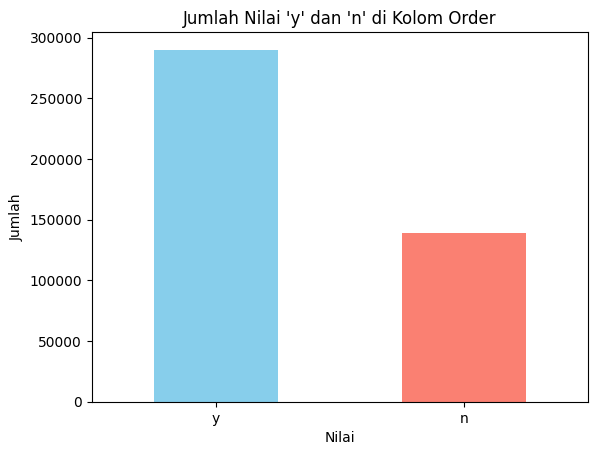

In [ ]:
# Menghitung jumlah masing-masing nilai 'y' dan 'n' di kolom 'order'
order_counts = df_data_train['order'].value_counts()

# Membuat plot batang
order_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Jumlah Nilai 'y' dan 'n' di Kolom Order")
plt.xlabel("Nilai")
plt.ylabel("Jumlah")
plt.xticks(rotation=0)  # Menjaga label sumbu x tetap horizontal
plt.show()

####Kesimpulan
####Nilai 'y' memiliki jumlah yang lebih tinggi dibandingkan dengan nilai 'n'.
####Ini menunjukkan bahwa terdapat lebih banyak entri dengan nilai 'y' dalam kolom "Order" daripada entri dengan nilai 'n'.
####Perbedaan jumlah antara nilai 'y' dan 'n' cukup signifikan, yang mungkin menunjukkan bahwa kondisi yang diwakili oleh 'y' lebih umum atau lebih sering terjadi dibandingkan dengan kondisi yang diwakili oleh 'n'

##Histogram untuk menunjukkan distribusi durasi sesi dalam satuan detik

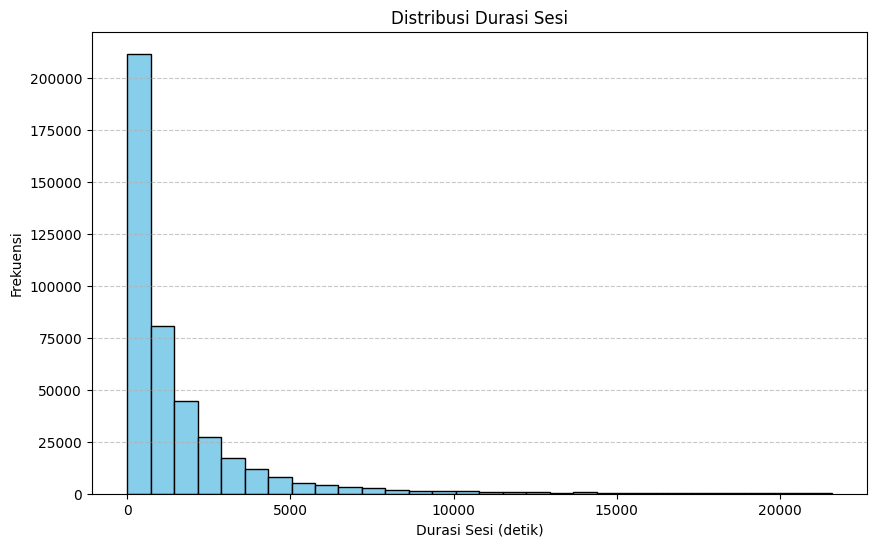

In [ ]:
# Ubah kolom duration ke tipe numerik, sambil menangani nilai yang bukan angka
df_data_train['duration'] = pd.to_numeric(df_data_train['duration'], errors='coerce')

# Buat histogram untuk duration: Plot histogram untuk melihat distribusi durasi sesi.
plt.figure(figsize=(10, 6))
plt.hist(df_data_train['duration'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title("Distribusi Durasi Sesi")
plt.xlabel("Durasi Sesi (detik)")
plt.ylabel("Frekuensi")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# histogram untuk melihat distribusi waktu yang dihabiskan pengguna dalam satu sesi.
# banyak pengguna umumnya menghabiskan waktu singkat, dengan beberapa pengguna menghabiskan waktu lebih lama.

###Kesimpulan
####Sebagian besar durasi sesi berada di rentang yang sangat pendek (dekat dengan 0 detik), yang ditunjukkan oleh frekuensi tertinggi pada durasi sesi pendek.
####Distribusi durasi sesi tampak right-skewed atau miring ke kanan, yang berarti hanya sedikit sesi yang memiliki durasi sangat panjang, sedangkan sebagian besar sesi berlangsung singkat.
####Jumlah sesi dengan durasi lebih dari 5000 detik menurun tajam, menunjukkan bahwa sesi berdurasi panjang adalah kasus yang jarang terjadi.

##Plot batang untuk menunjukkan perbandingan antara rata-rata jumlah klik produk dan rata-rata jumlah produk yang ditambahkan ke keranjang

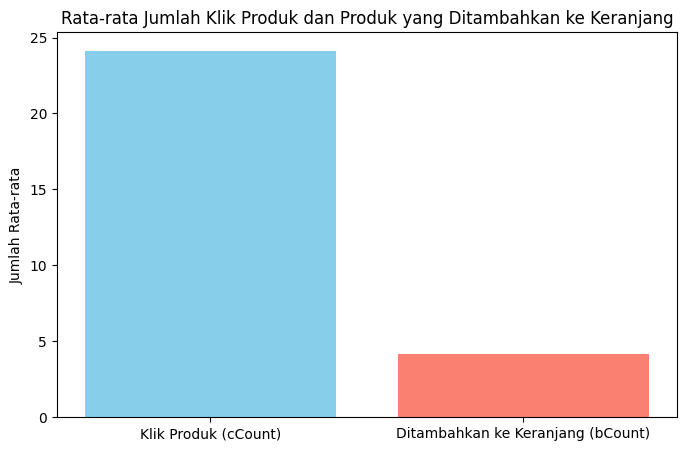

In [ ]:
# Konversi kolom 'cCount' dan 'bCount' ke numerik
df_data_train['cCount'] = pd.to_numeric(df_data_train['cCount'], errors='coerce')
df_data_train['bCount'] = pd.to_numeric(df_data_train['bCount'], errors='coerce')

# Menghitung rata-rata
avg_cCount = df_data_train['cCount'].mean()
avg_bCount = df_data_train['bCount'].mean()

# Plot batang untuk rata-rata cCount dan bCount
plt.figure(figsize=(8, 5))
plt.bar(['Klik Produk (cCount)', 'Ditambahkan ke Keranjang (bCount)'], [avg_cCount, avg_bCount], color=['skyblue', 'salmon'])
plt.title('Rata-rata Jumlah Klik Produk dan Produk yang Ditambahkan ke Keranjang')
plt.ylabel('Jumlah Rata-rata')
plt.show()

# Banyak pengguna yang hanya melihat-lihat produk dan tidak memasukkannya kedalam keranjang mereka

###Kesimpulan
####Rata-rata Jumlah Klik Produk Jauh Lebih Tinggi: Terlihat jelas bahwa rata-rata jumlah klik produk jauh lebih tinggi dibandingkan dengan rata-rata jumlah produk yang ditambahkan ke keranjang. Ini mengindikasikan bahwa banyak pengguna yang melihat-lihat produk (klik) tetapi tidak melanjutkan ke tahap pembelian (menambahkan ke keranjang).

####Tingkat Konversi Rendah: Perbedaan yang signifikan antara jumlah klik dan jumlah produk yang ditambahkan ke keranjang menunjukkan tingkat konversi yang relatif rendah. Dengan kata lain, persentase pengguna yang setelah melihat produk langsung menambahkannya ke keranjang masih cukup kecil.

##Plot batang untuk menunjukkan distribusi frekuensi usia pelanggan

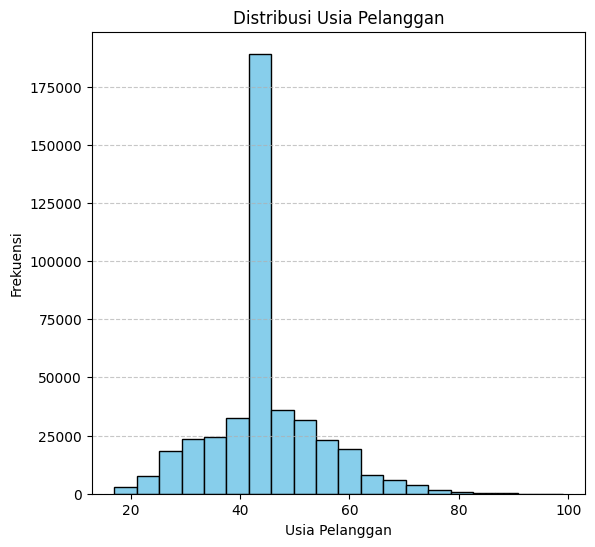

In [ ]:
# Konversi kolom 'age' dan 'payments' ke tipe numerik, menangani nilai non-numerik
df_data_train['age'] = pd.to_numeric(df_data_train['age'], errors='coerce')

# Mengatur ukuran figure
plt.figure(figsize=(14, 6))

# Histogram distribusi usia pelanggan
plt.subplot(1, 2, 1)
plt.hist(df_data_train['age'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title('Distribusi Usia Pelanggan')
plt.xlabel('Usia Pelanggan')
plt.ylabel('Frekuensi')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# menampilkan rentang usia para pelanggan, ini bisa membantu mengetahui daya beli, minat terhadap produk, serta behaviour yang dapat membantu prediksi

###Kesimpulan
####Berdasarkan analisis di atas, dapat disimpulkan bahwa target pasar utama dari produk atau layanan ini adalah kelompok usia muda hingga dewasa, dengan fokus utama pada rentang usia 40 tahun. Hal ini dapat menjadi pertimbangan penting dalam menyusun strategi pemasaran dan pengembangan produk.

##Plot unutk menganalisis pembelian berdasarkan status online

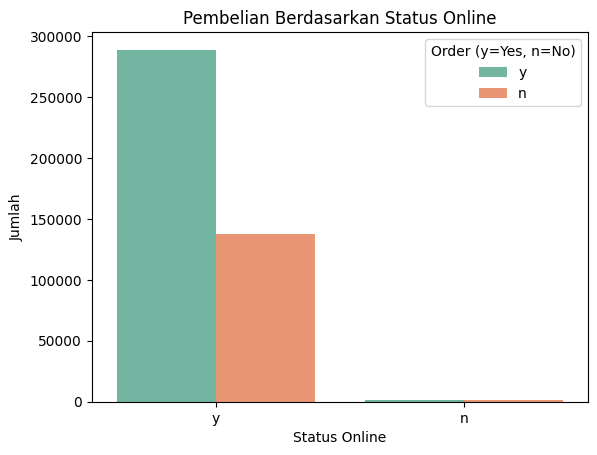

In [ ]:
sns.countplot(x='onlineStatus', hue='order', data=df_data_train, palette='Set2')
plt.title('Pembelian Berdasarkan Status Online')
plt.xlabel('Status Online')
plt.ylabel('Jumlah')
plt.legend(title='Order (y=Yes, n=No)')
plt.show()

# bisa dilihat bahwa ada beberapa order yang terjadi namun dalam kondisi atau status tidak online. hal ini bisa terjadi karena beberapa faktor:
# 1. kesalahan pencatatan dalam dataset, Misalnya, sistem mencatat status sebagai "offline" pada saat pembelian, padahal pengguna terhubung.
# 2. pemprosesan pesanan otomatis setelah pengguna melakukan tindakan awal, seperti "pre-order" atau "order confirmation."
# 3. Jika platform mendukung fitur seperti "cash on delivery", maka status pengguna di platform mungkin tetap offline.

###Kesimpulan
####Berdasarkan plot yang disajikan, dapat disimpulkan bahwa mayoritas pembelian terjadi melalui platform online. Hal ini ditunjukkan oleh batang berwarna hijau yang jauh lebih tinggi dibandingkan dengan batang berwarna oranye. Ini mengindikasikan bahwa fitur atau layanan online yang disediakan sangat efektif dalam mendorong konsumen untuk melakukan pembelian

# Prediksi

##Model Random Forest

###Model ini dapat digunakan untuk memprediksi apakah seorang pelanggan akan melakukan order atau tidak berdasarkan fitur-fitur yang diberikan

In [ ]:
# Merge df_data_train and df_data_class based on sessionNo to get the 'order' labels
df_data_class_rf = df_data_class.merge(df_data_train[['sessionNo', 'order']], on='sessionNo', how='left')

# Now, 'order' should be available in df_data_class

# 1. Prepare the training data
X = df_data_train.drop('order', axis=1)
y = df_data_train['order'].map({'n': 0, 'y': 1})

# 2. Preprocess training data
categorical_features = ['onlineStatus', 'availability']
if 'transType' in X.columns:
    categorical_features.append('transType')
if 'hour' in X.columns:
    categorical_features.append('hour')
if 'dayofweek' in X.columns:
    categorical_features.append('dayofweek')

# Convert problematic columns to numeric before one-hot encoding
for col in ['customerNo', 'maxVal', 'customerScore', 'accountLifetime', 'payments', 'age', 'address', 'lastOrder']:
    if col in X.columns:  # Check if column exists
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)  # Convert to numeric, fill NaNs with 0

# One-hot encode categorical features
X = pd.get_dummies(X, columns=categorical_features)

# Convert other potentially problematic columns to numeric
for col in ['cMinPrice', 'cMaxPrice', 'cSumPrice', 'bMinPrice', 'bMaxPrice', 'bSumPrice', 'bStep']:
    if col in X.columns:  # Check if column exists
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)  # Convert to numeric, fill NaNs with 0

# 3. Prepare the test data
if 'order' in df_data_class_rf.columns:
    X_test = df_data_class_rf.drop('order', axis=1)
else:
    # Handle the case where 'order' is not found
    print("Warning: 'order' column not found in df_data_class")
    # You might need to investigate why the merge didn't add the 'order' column
    # or consider a different approach to preparing your test data.
    # For now, we'll continue without dropping 'order' (which may cause issues later)
    X_test = df_data_class_rf.copy()

# Convert problematic columns to numeric before one-hot encoding
for col in ['customerNo', 'maxVal', 'customerScore', 'accountLifetime', 'payments', 'age', 'address', 'lastOrder']:
    if col in X_test.columns:  # Check if column exists
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce').fillna(0)  # Convert to numeric, fill NaNs with 0

# One-hot encode categorical features, ensuring alignment with training data
X_test = pd.get_dummies(X_test, columns=categorical_features)

# Align columns between training and test data
missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
extra_cols = set(X_test.columns) - set(X.columns)
for col in extra_cols:
    X_test = X_test.drop(columns=[col]) # Drop extra columns from test set

X_test = X_test[X.columns]  # Reorder columns to match training data

# Convert other potentially problematic columns to numeric
for col in ['cMinPrice', 'cMaxPrice', 'cSumPrice', 'bMinPrice', 'bMaxPrice', 'bSumPrice', 'bStep']:
    if col in X_test.columns:  # Check if column exists
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce').fillna(0)  # Convert to numeric, fill NaNs with 0

# 4. Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf_model.fit(X, y)

# 5. Predict and evaluate
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(df_data_class_rf['order'].map({'n': 0, 'y': 1}), y_pred)
print(f"Accuracy: {accuracy}")

# 6. Predict for each session in df_data_class
df_data_class_rf['prediction'] = rf_model.predict(X_test)

# Remove duplicate session numbers and keep only the first prediction
df_data_class_rf = df_data_class_rf[['sessionNo', 'prediction']].drop_duplicates(subset=['sessionNo'], keep='first')

# Display the predictions for each session
df_data_class_rf[['sessionNo', 'prediction']].head(5111)

Accuracy: 0.5910952041591829


,sessionNo,prediction
0,1,1
27,2,1
82,3,1
197,4,1
209,5,1
...,...,...
379978,5107,0
379980,5108,0
380012,5109,0
380072,5110,0


###Output
####Akurasi: Model mencapai akurasi sebesar 0.591, artinya model dapat memprediksi dengan benar sekitar 59% dari data uji.
####Prediksi untuk Setiap Sesi: Tabel yang menampilkan prediksi untuk setiap sesi, menunjukkan apakah pelanggan akan melakukan order (1) atau tidak (0).

## Model XGBoost

###Model ini untuk memprediksi apakah pelanggan akan melakukan order (y) atau tidak (n)

In [ ]:
# Merge df_data_train and df_data_class based on sessionNo to get the 'order' labels
df_data_class_xg = df_data_class.merge(df_data_train[['sessionNo', 'order']], on='sessionNo', how='left')

# Now, 'order' should be available in df_data_class

# 1. Prepare the training data
X = df_data_train.drop('order', axis=1)
y = df_data_train['order'].map({'n': 0, 'y': 1})

# 2. Preprocess training data
categorical_features = ['onlineStatus', 'availability']
if 'transType' in X.columns:
    categorical_features.append('transType')
if 'hour' in X.columns:
    categorical_features.append('hour')
if 'dayofweek' in X.columns:
    categorical_features.append('dayofweek')

# Convert problematic columns to numeric before one-hot encoding
for col in ['customerNo', 'maxVal', 'customerScore', 'accountLifetime', 'payments', 'age', 'address', 'lastOrder']:
    if col in X.columns:  # Check if column exists
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)  # Convert to numeric, fill NaNs with 0

# One-hot encode categorical features
X = pd.get_dummies(X, columns=categorical_features)

# Convert other potentially problematic columns to numeric
for col in ['cMinPrice', 'cMaxPrice', 'cSumPrice', 'bMinPrice', 'bMaxPrice', 'bSumPrice', 'bStep']:
    if col in X.columns:  # Check if column exists
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)  # Convert to numeric, fill NaNs with 0



# 3. Prepare the test data
if 'order' in df_data_class_xg.columns:
    X_test = df_data_class_xg.drop('order', axis=1)
else:
    # Handle the case where 'order' is not found
    print("Warning: 'order' column not found in df_data_class")
    # You might need to investigate why the merge didn't add the 'order' column
    # or consider a different approach to preparing your test data.
    # For now, we'll continue without dropping 'order' (which may cause issues later)
    X_test = df_data_class_xg.copy()

# Convert problematic columns to numeric before one-hot encoding
for col in ['customerNo', 'maxVal', 'customerScore', 'accountLifetime', 'payments', 'age', 'address', 'lastOrder']:
    if col in X_test.columns:  # Check if column exists
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce').fillna(0)  # Convert to numeric, fill NaNs with 0

# One-hot encode categorical features, ensuring alignment with training data
X_test = pd.get_dummies(X_test, columns=categorical_features)

# Align columns between training and test data
missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
extra_cols = set(X_test.columns) - set(X.columns)
for col in extra_cols:
    X_test = X_test.drop(columns=[col]) # Drop extra columns from test set

X_test = X_test[X.columns]  # Reorder columns to match training data


# Convert other potentially problematic columns to numeric
for col in ['cMinPrice', 'cMaxPrice', 'cSumPrice', 'bMinPrice', 'bMaxPrice', 'bSumPrice', 'bStep']:
    if col in X_test.columns:  # Check if column exists
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce').fillna(0)  # Convert to numeric, fill NaNs with 0

# 4. Create and train the model
model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X, y)

# 5. Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(df_data_class_xg['order'].map({'n': 0, 'y': 1}), y_pred)
print(f"Accuracy: {accuracy}")

# 5. Predict for each session in df_data_class
df_data_class_xg['prediction'] = model.predict(X_test)

# Remove duplicate session numbers and keep only the first prediction
df_data_class_xg = df_data_class_xg[['sessionNo', 'prediction']].drop_duplicates(subset=['sessionNo'], keep='first')

# Display the predictions for each session

df_data_class_xg[['sessionNo', 'prediction']].head(5111)


Accuracy: 0.542100681889304


,sessionNo,prediction
0,1,1
27,2,1
82,3,1
197,4,1
209,5,1
...,...,...
379978,5107,0
379980,5108,0
380012,5109,0
380072,5110,0


###Output
####Akurasi model (0.54) masih bisa ditingkatkan. Teknik penanganan data imbalanced dan penyesuaian hiperparameter XGBoost dapat dicoba